In [2]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [3]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [4]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 3s 78ms/step - loss: 0.1797 - val_loss: 0.0436
Epoch 2/100
16/16 [==============================] - 1s 48ms/step - loss: 0.0232 - val_loss: 0.0400
Epoch 3/100
16/16 [==============================] - 1s 53ms/step - loss: 0.0109 - val_loss: 0.0180
Epoch 4/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 5/100
16/16 [==============================] - 1s 78ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6/100
16/16 [==============================] - 1s 79ms/step - loss: 6.1150e-04 - val_loss: 0.0016
Epoch 7/100
16/16 [==============================] - 1s 54ms/step - loss: 4.4552e-04 - val_loss: 0.0015
Epoch 8/100
16/16 [==============================] - 1s 84ms/step - loss: 4.4370e-04 - val_loss: 0.0014
Epoch 9/100
16/16 [==============================] - 1s 46ms/step - loss: 4.1148e-04 - val_loss: 0.0015
Epoch 10/100
16/16 [==============================] - 1s 47ms/step - loss: 4.0305e-0

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 9ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 25405.598550351246


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.07525817304849625], [0.07486589252948761], [0.07324951887130737], [0.07124555855989456], [0.06909254938364029], [0.06686669588088989], [0.06459657102823257], [0.062294378876686096], [0.059965699911117554], [0.057613272219896317], [0.05523846298456192], [0.05284200236201286], [0.050424326211214066], [0.04798565432429314], [0.045526113361120224], [0.043045781552791595], [0.04054470360279083], [0.03802287578582764], [0.0354803130030632], [0.03291702643036842], [0.030332989990711212], [0.027728237211704254], [0.02510274201631546], [0.022456517443060875], [0.01978958025574684], [0.017101936042308807], [0.01439360436052084], [0.011664615012705326], [0.008915005251765251], [0.006144809070974588], [0.0033540669828653336], [0.0005428362637758255], [-0.0022888267412781715], [-0.005140853114426136], [-0.008013174869120121], [-0.01090571191161871], [-0.013818376697599888], [-0.01675107330083847], [-0.019703704863786697], [-0.022676151245832443], [-0.02566830813884735], [-0.02868005260825157], 

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16429.90013805],
       [16397.68763095],
       [16264.95749164],
       [16100.4002867 ],
       [15923.60378519],
       [15740.82559896],
       [15554.41202655],
       [15365.36521584],
       [15174.1434139 ],
       [14980.97146161],
       [14785.96162644],
       [14589.17386596],
       [14390.64397116],
       [14190.38999049],
       [13988.42232476],
       [13784.74739799],
       [13579.36888105],
       [13372.28646803],
       [13163.50138256],
       [12953.01454236],
       [12740.82380608],
       [12526.93192688],
       [12311.33676341],
       [12094.03938635],
       [11875.04117228],
       [11654.34258005],
       [11431.94521567],
       [11207.85152638],
       [10982.06457125],
       [10754.58714167],
       [10525.42256436],
       [10294.57554264],
       [10062.05070331],
       [ 9827.85370566],
       [ 9591.99013245],
       [ 9354.46656067],
       [ 9115.2901791 ],
       [ 8874.46886483],
       [ 8632.01057141],
       [ 8387.9251643 ],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(466,)


(466, 1)

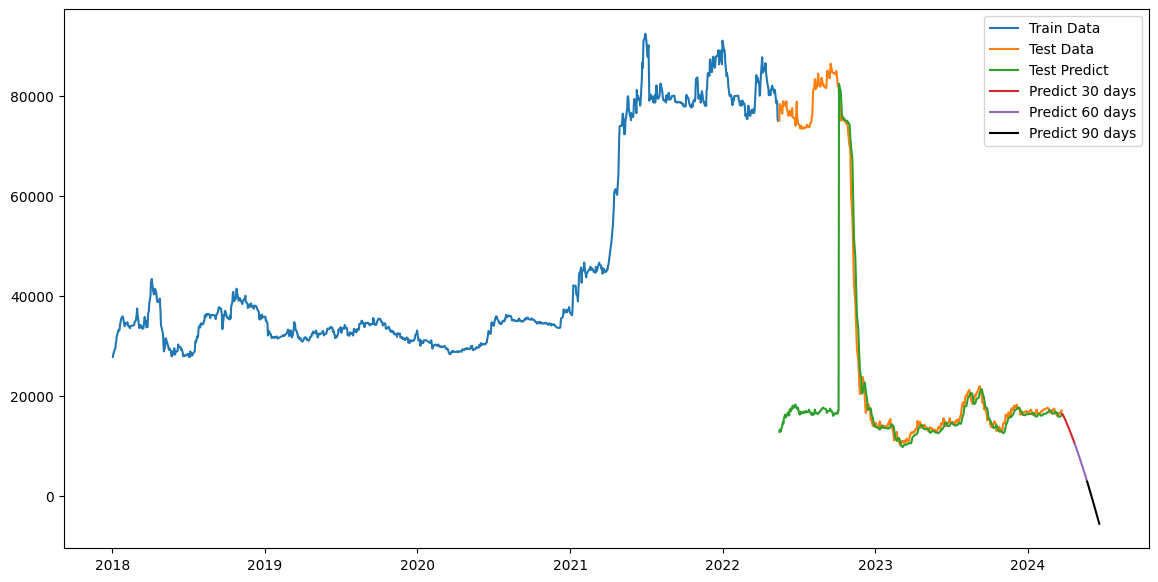

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()